In [20]:
# Import required libraries
import sqlite3
import pandas as pd

In [21]:
# Step 1: Connect to the SQLite database
DATABASE_NAME = "csv_data.db"
conn = sqlite3.connect(DATABASE_NAME)

In [22]:
# Step 2: Get the list of all tables in the database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

In [23]:
print("Tables in the database:")
for table in tables:
  print(table[0])

Tables in the database:
Actual_Daily_Sales
LLMData
Product_master
Market_data


In [24]:
# Step 3: Function to display data from a specific table
def display_table_data(table_name):
  query = f"SELECT * FROM '{table_name}' LIMIT 5;"
  df = pd.read_sql_query(query, conn)
  print(f"\nFirst 5 rows of table '{table_name}':")
  display(df)

In [25]:
# Step 4: Display data from each table
for table in tables:
  display_table_data(table[0])


First 5 rows of table 'Actual_Daily_Sales':


,Country,Product,FY Year,Month,Actual Sales,Budget,LE (Latest Estimate) Estimation of sales for running 12 months
0,Russia,P#1,2024,1,680066,680311,680342
1,Russia,P#1,2024,2,984269,984514,984545
2,Russia,P#1,2024,3,692327,692572,692603
3,Russia,P#1,2024,4,943126,943371,943402
4,Russia,P#1,2024,5,976196,976441,976472



First 5 rows of table 'LLMData':


,ID,Country,Product,FY Year,Month,Actual Sales,Budget,LE (Latest Estimate) Estimation of sales for running 12 months
0,1,Russia,P#1 - INS,2024,1,680066,680311,680342
1,2,Russia,P#1 - INS,2024,2,984269,984514,984545
2,3,Russia,P#1 - INS,2024,3,692327,692572,692603
3,4,Russia,P#1 - INS,2024,4,943126,943371,943402
4,5,Russia,P#1 - INS,2024,5,976196,976441,976472



First 5 rows of table 'Product_master':


,PK_SKU_ID (Product Code),Molecule,PackSize (How many tablets in each pack),Channel,LaunchYear (Product Launch Year),LaunchMonth,LaunchDate,Brand
0,P#1,A,1,None,2021,June,06/01/2021,Carboprost
1,P#2,B,1,Oncology,2020,June,06/01/2020,Cisplatin
2,P#3,C,10,ASCO,2022,April,04/01/2022,Paracetamol
3,P#4,D,8,OncLive,2021,May,05/01/2021,Aspirin
4,P#5,E,1,CME,2023,January,01/01/2023,Eye Plus



First 5 rows of table 'Market_data':


,Country,Product,FY Year,Month,DRL Sales,Market Sales
0,Russia,P#1,2024,1,680066,3518031
1,Russia,P#1,2024,2,984269,3860511
2,Russia,P#1,2024,3,692327,2484693
3,Russia,P#1,2024,4,943126,2562118
4,Russia,P#1,2024,5,976196,3169055


## Langgraph

In [1]:

from langchain_community.utilities import SQLDatabase
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
import os
from dotenv import load_dotenv

load_dotenv()

db = SQLDatabase.from_uri("sqlite:///csv_data.db")

In [10]:
# aoai_api_key = os.getenv("AZURE_OPENAI_API_KEY") 
# aoai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
aoai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")
aoai_api_key = os.getenv("A_KEY") 
aoai_endpoint = os.getenv("A_ENDPOINT")
llm = AzureChatOpenAI(
    model="gpt-4",
    deployment_name="gpt-4",
    api_key=aoai_api_key,
    azure_endpoint=aoai_endpoint,
    api_version=aoai_api_version,
)

In [12]:
llm.invoke("which model am I using")

AIMessage(content="As an AI, I don't have specific information about your current model usage unless it is specified in the context of the conversation. Are you referring to a model of a device, a car, or a theoretical model? Could you provide more details?", response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 12, 'total_tokens': 62}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-9cf34bb1-194f-4a12-aba7-8fae38c81427-0', usage_metadata={'input_tokens': 12, 'output_tokens': 50, 'total_tokens': 62})

In [28]:
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Market_data LIMIT 10;")

sqlite
['Actual_Daily_Sales', 'LLMData', 'Market_data', 'Product_master']


"[('Russia', 'P#1', 2024, 1, 680066, 3518031), ('Russia', 'P#1', 2024, 2, 984269, 3860511), ('Russia', 'P#1', 2024, 3, 692327, 2484693), ('Russia', 'P#1', 2024, 4, 943126, 2562118), ('Russia', 'P#1', 2024, 5, 976196, 3169055), ('Russia', 'P#1', 2024, 6, 908763, 2294078), ('Russia', 'P#1', 2024, 7, 953829, 7123710), ('Russia', 'P#1', 2024, 8, 554489, 1511181), ('Russia', 'P#1', 2024, 9, 663627, 4934935), ('Russia', 'P#1', 2024, 10, 797375, 3829590)]"

In [29]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [30]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))

print(get_schema_tool.invoke("Market_data"))

Actual_Daily_Sales, LLMData, Market_data, Product_master

CREATE TABLE "Market_data" (
	"Country" TEXT, 
	"Product" TEXT, 
	"FY Year" INTEGER, 
	"Month" INTEGER, 
	"DRL Sales" INTEGER, 
	"Market Sales" INTEGER
)

/*
3 rows from Market_data table:
Country	Product	FY Year	Month	DRL Sales	Market Sales
Russia	P#1	2024	1	680066	3518031
Russia	P#1	2024	2	984269	3860511
Russia	P#1	2024	3	692327	2484693
*/


In [31]:
from langchain_core.tools import tool



@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


print(db_query_tool.invoke("SELECT * FROM Market_data LIMIT 10;"))

[('Russia', 'P#1', 2024, 1, 680066, 3518031), ('Russia', 'P#1', 2024, 2, 984269, 3860511), ('Russia', 'P#1', 2024, 3, 692327, 2484693), ('Russia', 'P#1', 2024, 4, 943126, 2562118), ('Russia', 'P#1', 2024, 5, 976196, 3169055), ('Russia', 'P#1', 2024, 6, 908763, 2294078), ('Russia', 'P#1', 2024, 7, 953829, 7123710), ('Russia', 'P#1', 2024, 8, 554489, 1511181), ('Russia', 'P#1', 2024, 9, 663627, 4934935), ('Russia', 'P#1', 2024, 10, 797375, 3829590)]


In [32]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

Question Interpretation:
- For certain questions, rephrase or expand the query to ensure comprehensive answers:
    Example1: 
    User: "Show me Sales Performance by country"
    Interpreted as: "Show me actual sales, Budget, LE (Latest Estimate), by country"
    Example 2:
    User:"Show me market share percentage for DRL for Russia for each brand wise"
    Interpreted as: -Filter data on the country = Russia
                    - Group by Product and calculate total DRL Sales and Market Sales
                    - Calculate the market share percentage for each product
                    - Finally map each product with their brand name

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | llm.bind_tools(
    [db_query_tool], tool_choice="required"
)

query_check.invoke({"messages": [("user", "SELECT * FROM Market_data  LIMIT 10;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pvDSID5ArIoxiVBwThEKvTqN', 'function': {'arguments': '{"query":"SELECT * FROM Market_data LIMIT 10;"}', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 363, 'total_tokens': 376}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-7fed3ab9-b785-4252-8cdc-3178141e660d-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Market_data LIMIT 10;'}, 'id': 'call_pvDSID5ArIoxiVBwThEKvTqN', 'type': 'tool_call'}], usage_metadata={'input_tokens': 363, 'output_tokens': 13, 'total_tokens': 376})

In [33]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages


# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Define a new graph
workflow = StateGraph(State)


# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = llm.bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")


# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

ENsure Question Interpretation:
        - For certain questions, rephrase or expand the query to ensure comprehensive answers:
            Example1: 
            User: "Show me Sales Performance by country"
            Interpreted as: "Show me actual sales, Budget, LE (Latest Estimate), by country"
            Example 2:
            User:"Show me market share percentage for DRL for Russia for each brand wise"
            Interpreted as: -Filter data on the country = Russia
                            - Group by Product and calculate total DRL Sales and Market Sales
                            - Calculate the market share percentage for each product
                            - Finally map each product with their brand name

Output the SQL query that answers the input question without a tool call.


You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | llm.bind_tools(
    [SubmitFinalAnswer]
)


def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))


# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

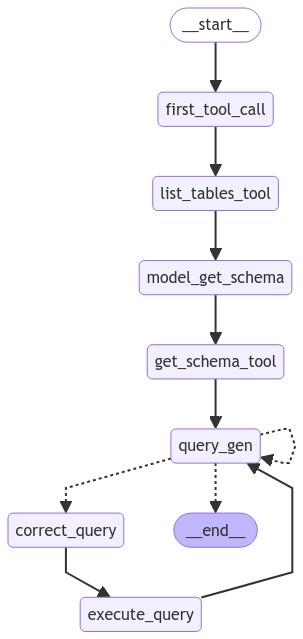

In [34]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [37]:
app

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden'], 'metadata': {}, 'configurable': {}}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x0000023ADE0F8E20>, skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['messages']), ChannelWrite<start:first_tool_call>(recurse=True, writes=[ChannelWriteEntry(channel='start:first_tool_call', value='__start__', skip_none=False, mapper=None)], require_at_least_one_of=None)]), 'first_tool_call': PregelNode(config={'tags': [], 'metadata': {}, 'configurable': {}}, channels={'messages': 'messages'}, triggers=['start:first_tool_call'], mapper=functools.partial(<function _coerce_state at 0x0000023ADE4D59E0>, <class '__main__.State'>), writers=[ChannelWrite<first_tool_call,messages>(recurse=True, writes=[ChannelWriteEntry(channel='first_tool_call', value='first_tool_call', ski

In [41]:
import json
# prompt="Show me the highest sold product for FY 2023"
# prompt="Show me market share percentage for DRL for Russia brand wise"
# prompt="Show me growth% by country for each brand from FY23 to Fy 24"
prompt="Show me Sales Performance by country"
# prompt="Show me market share percentage for DRL for Russia for each brand wise"
# prompt="Show me sales by product for FY 2024"
# prompt="Show me quarter wise sales trend by product and country"
messages = app.invoke(
    {"messages": [("user", prompt)]}
)
json_str = messages["messages"][-1].additional_kwargs["tool_calls"][0]["function"][
    "arguments"
]
json.loads(json_str)["final_answer"]

'Sales Performance by country:\n\n1. Brazil:\n   - Total Actual Sales: 80,340,019\n   - Total Budget: 82,147,309\n   - Total Latest Estimate: 82,036,663\n\n2. Russia:\n   - Total Actual Sales: 84,109,609\n   - Total Budget: 86,799,373\n   - Total Latest Estimate: 86,659,265'

In [42]:
from IPython.display import display, Markdown
display(Markdown(json.loads(json_str)["final_answer"]))

Sales Performance by country:

1. Brazil:
   - Total Actual Sales: 80,340,019
   - Total Budget: 82,147,309
   - Total Latest Estimate: 82,036,663

2. Russia:
   - Total Actual Sales: 84,109,609
   - Total Budget: 86,799,373
   - Total Latest Estimate: 86,659,265

### Working-1